# Heart Failure Prediction Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

## EDA

In [2]:
data = pd.read_csv('../data/data.csv')

In [3]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Descriptive Analytics

In [4]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
data.shape

(918, 12)

In [6]:
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

#### Univariate analisis

###### Numerical Features

In [7]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

In [8]:
def plot_variable_distribution(variable_name): 
    plt.figure(figsize=(20, 10))
    sns.histplot(data=data, x=f"{variable_name}")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/{variable_name}_distribution.png")
    plt.show()
    plt.close()

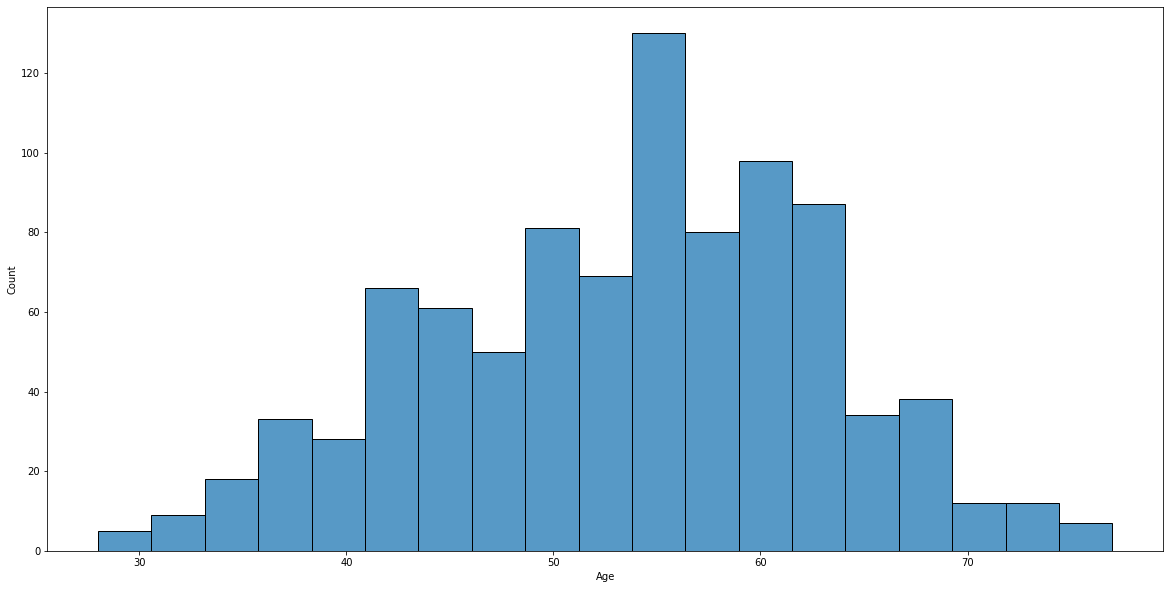

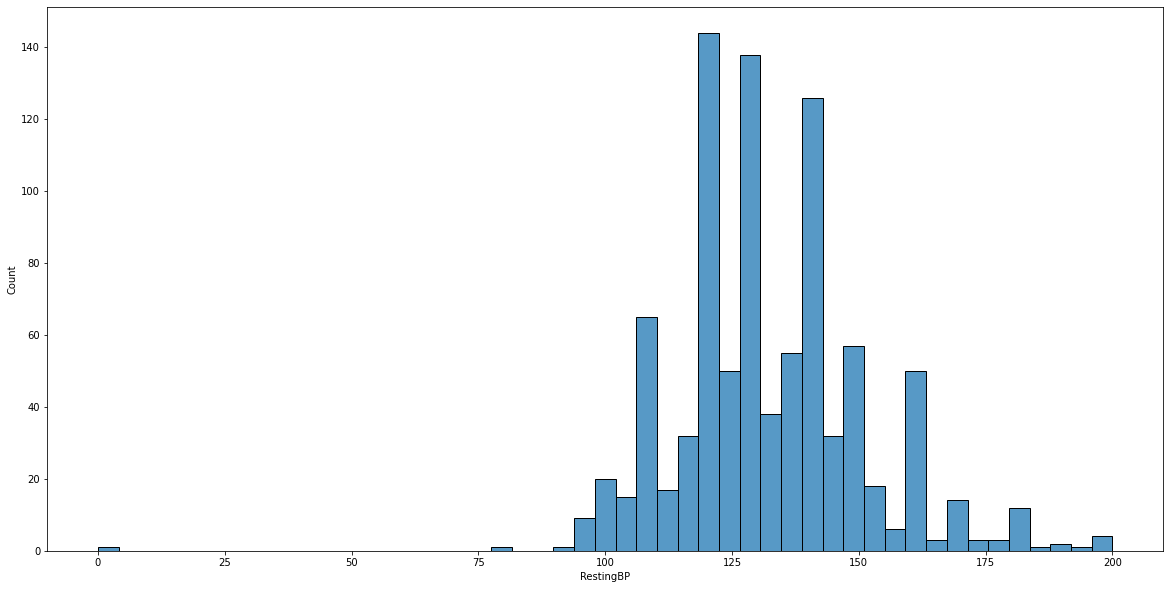

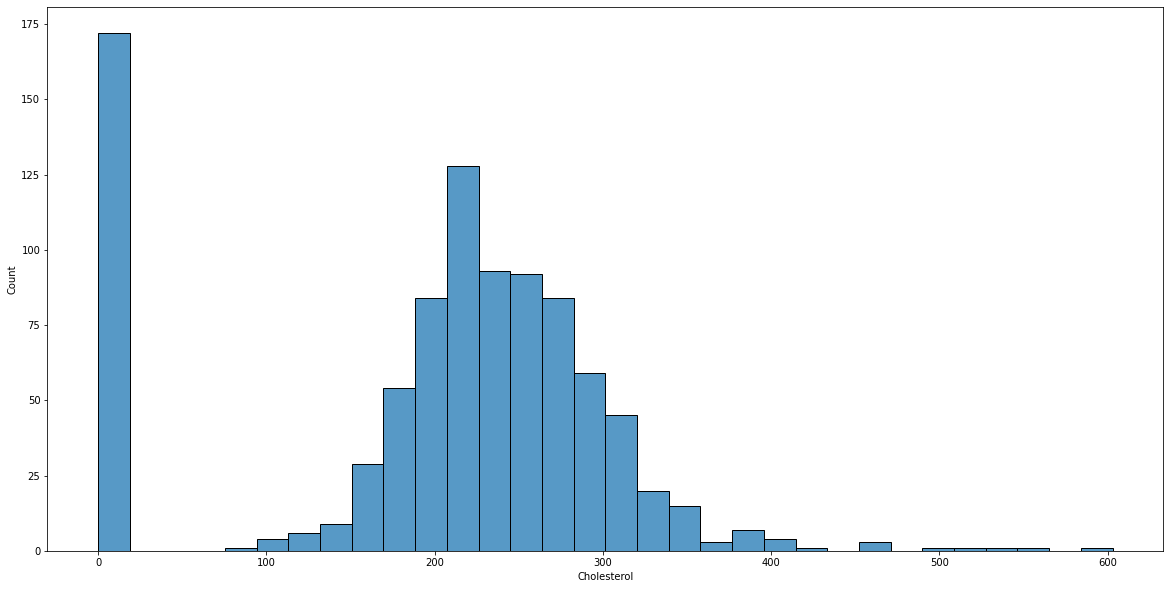

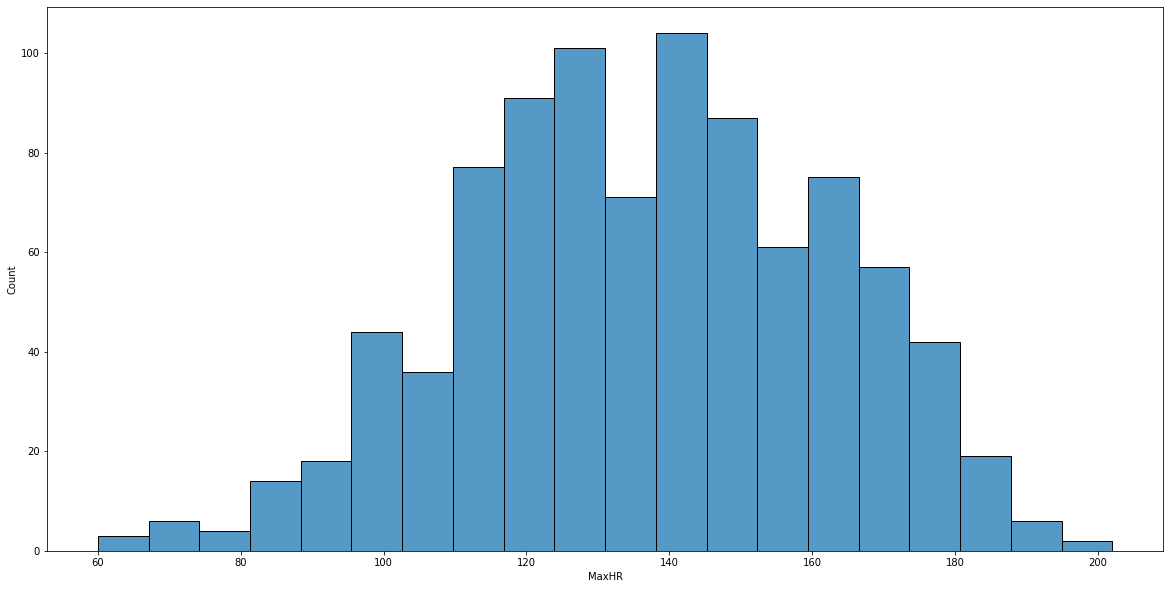

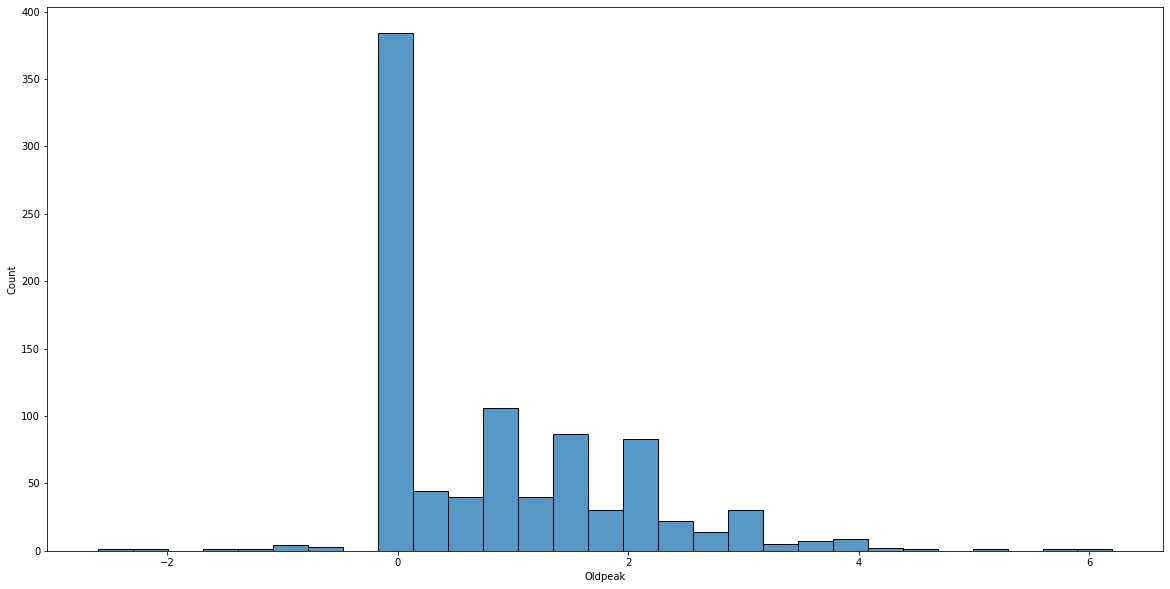

In [9]:
for numerical_feature in numerical_features:
    plot_variable_distribution(numerical_feature)

###### Categorical Features

In [10]:
def plot_categorical_feature_distribution(variable_name):
    plt.figure(figsize=(20, 10))
    ax = sns.countplot(x=f"{variable_name}", data=data)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
    plt.xlabel(f"{column}")
    plt.savefig(f"../results/EDA/{variable_name}_distribution.png")
    plt.show()
    plt.close()

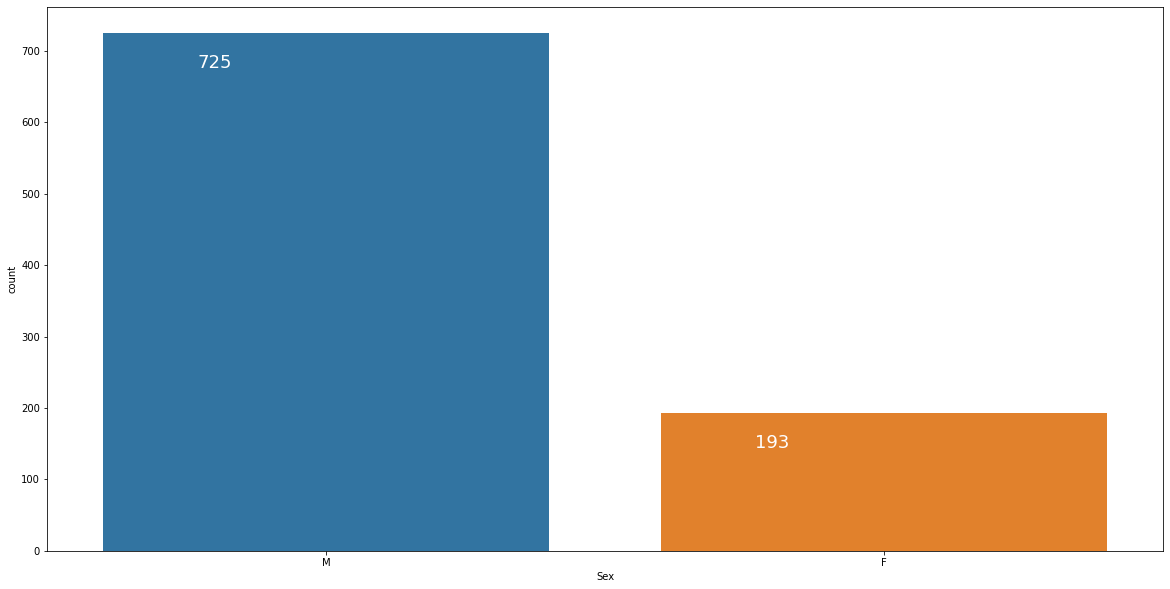

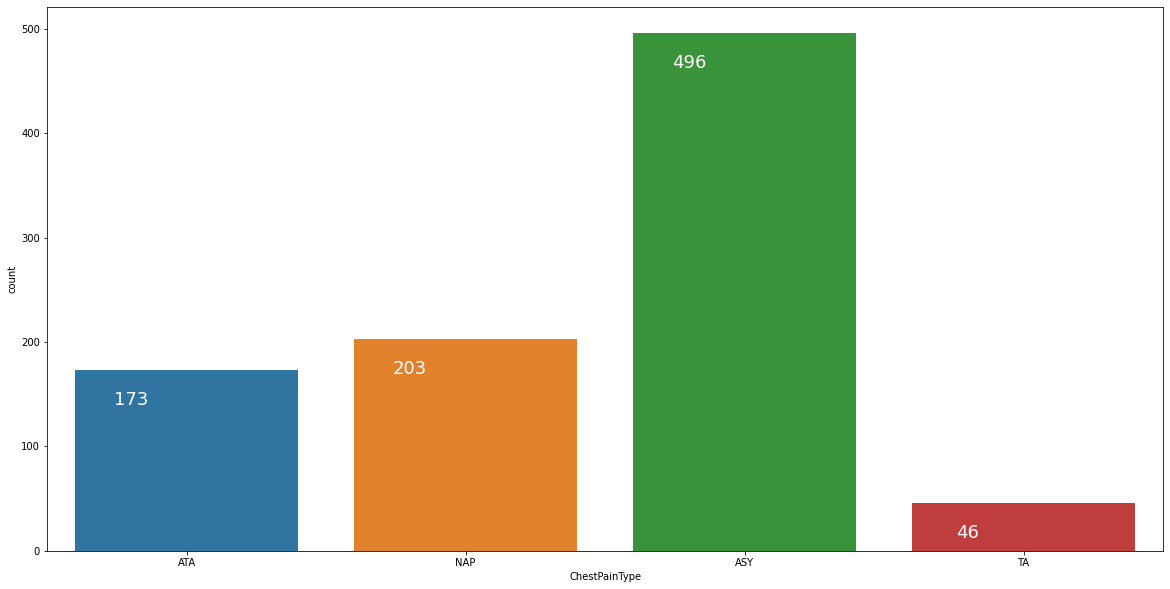

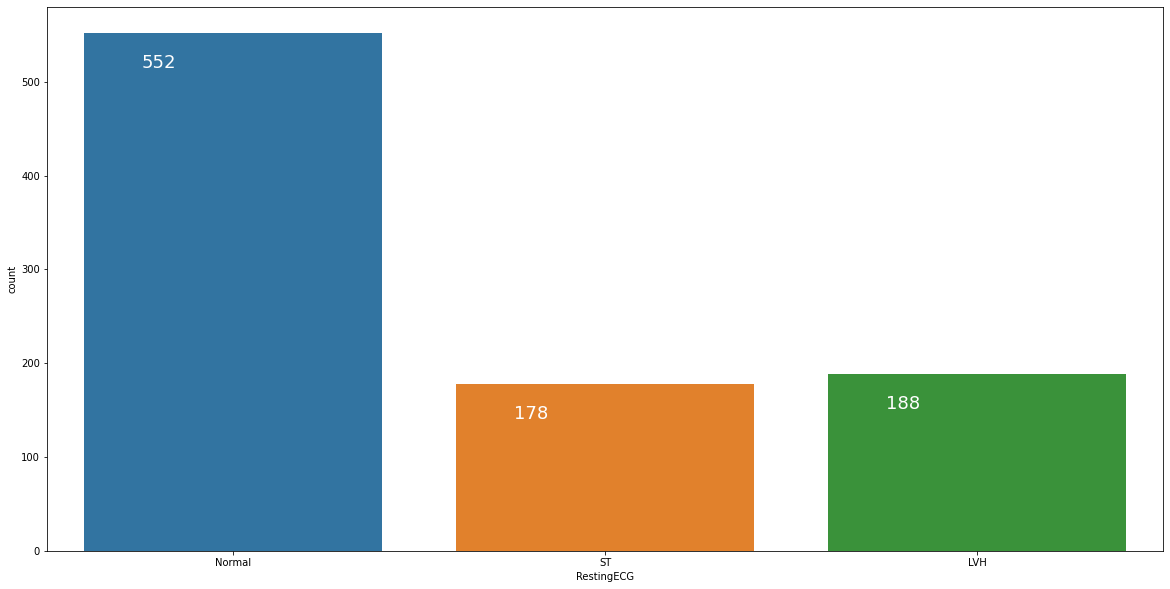

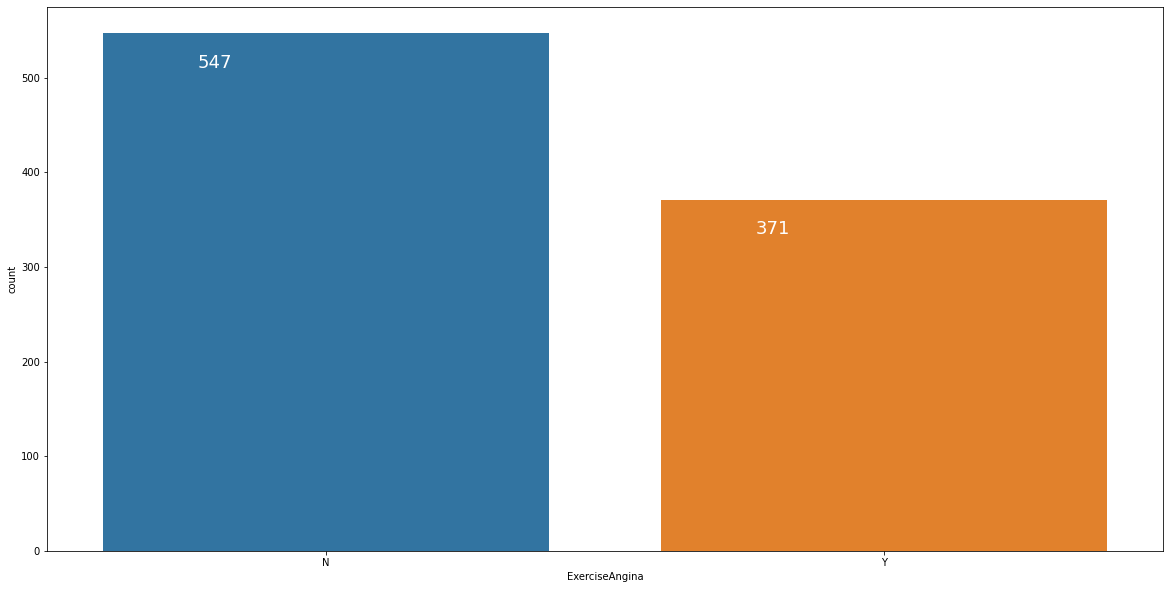

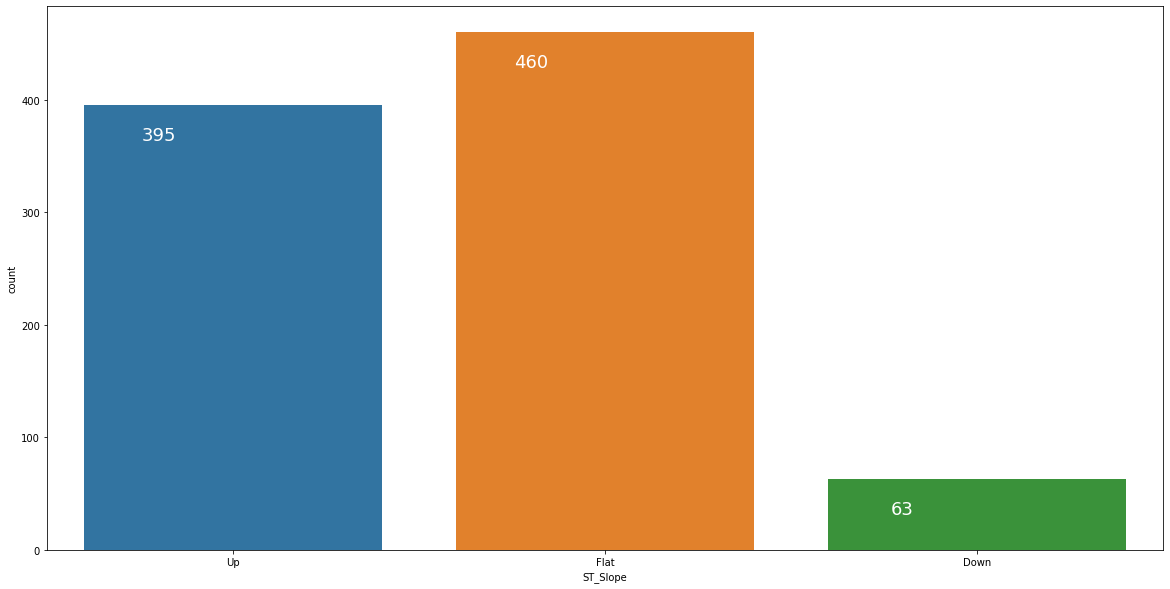

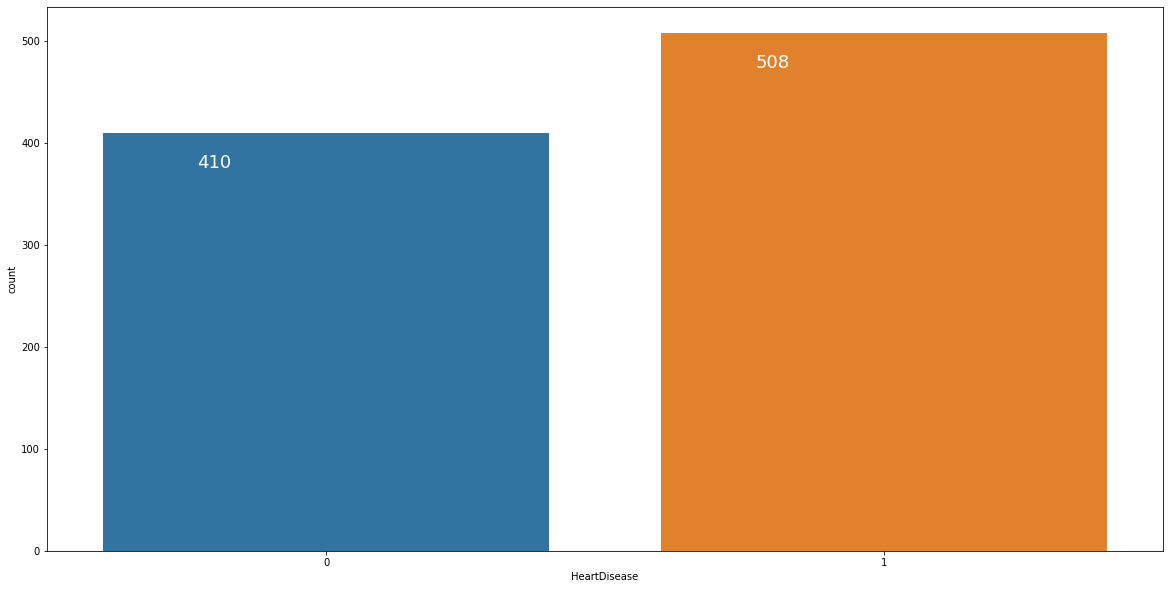

In [11]:
for column in categorical_features: 
    plot_categorical_feature_distribution(column)

We can conclude that the dataset is not imbalaced, since there is no minorty class and we have a almost 50 / 50 ratio between those how suffered a heart failure and those that no

### Missing Values

<AxesSubplot:>

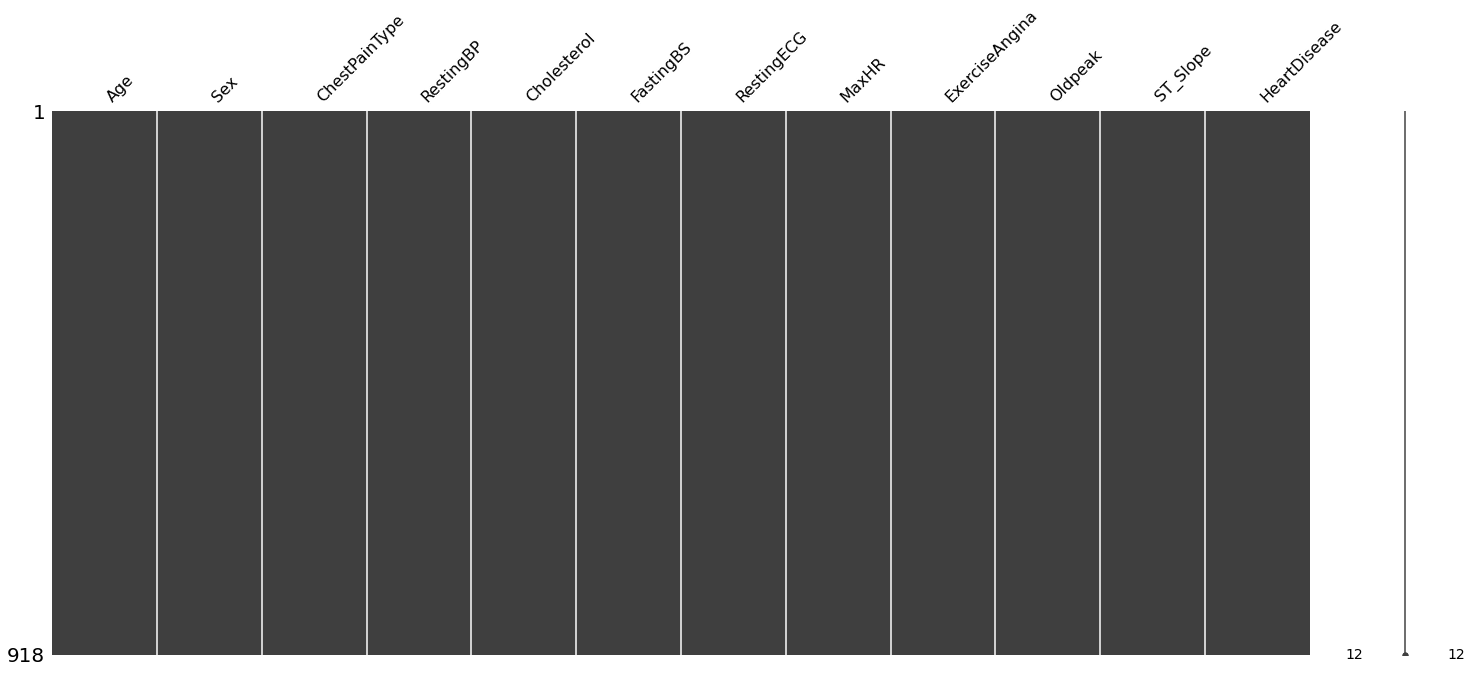

In [12]:
msno.matrix(data)

<AxesSubplot:>

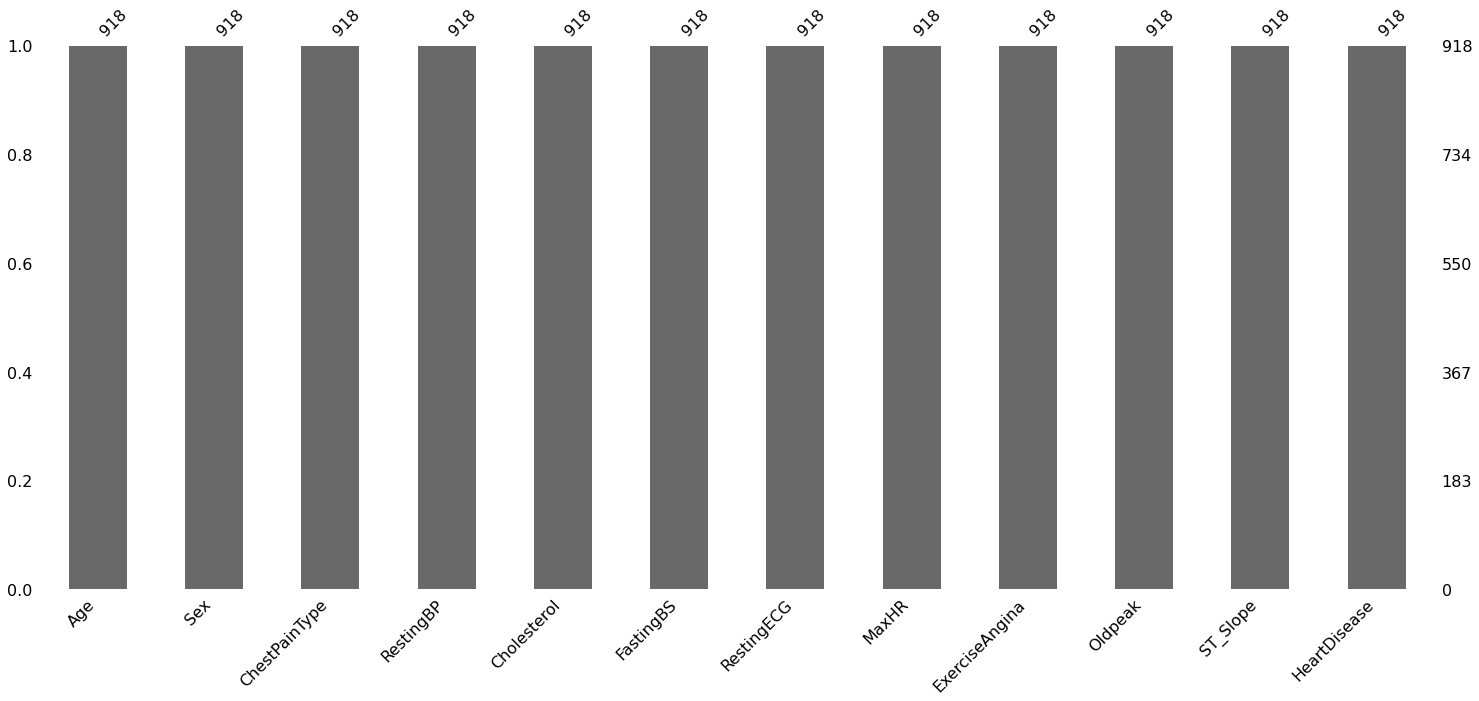

In [13]:
msno.bar(data)

There are no missing values in this dataset.

### Outlier Detection

In [15]:
def plot_intercuartile_range(variable_name):
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=data, x=f"{variable_name}")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/{variable_name}_outliers.png")
    plt.show()
    plt.close()

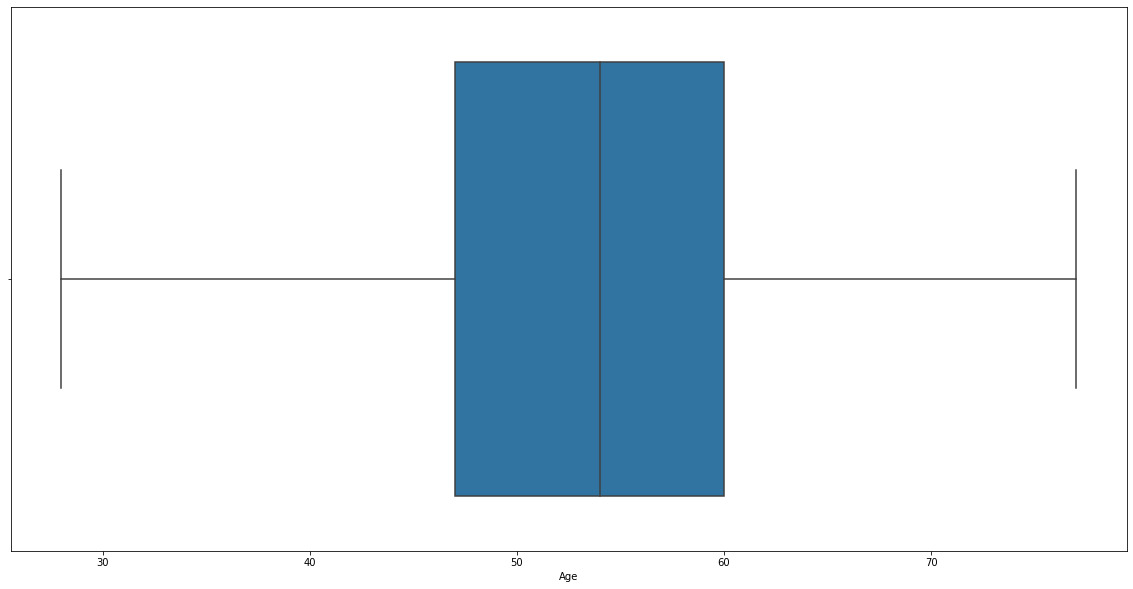

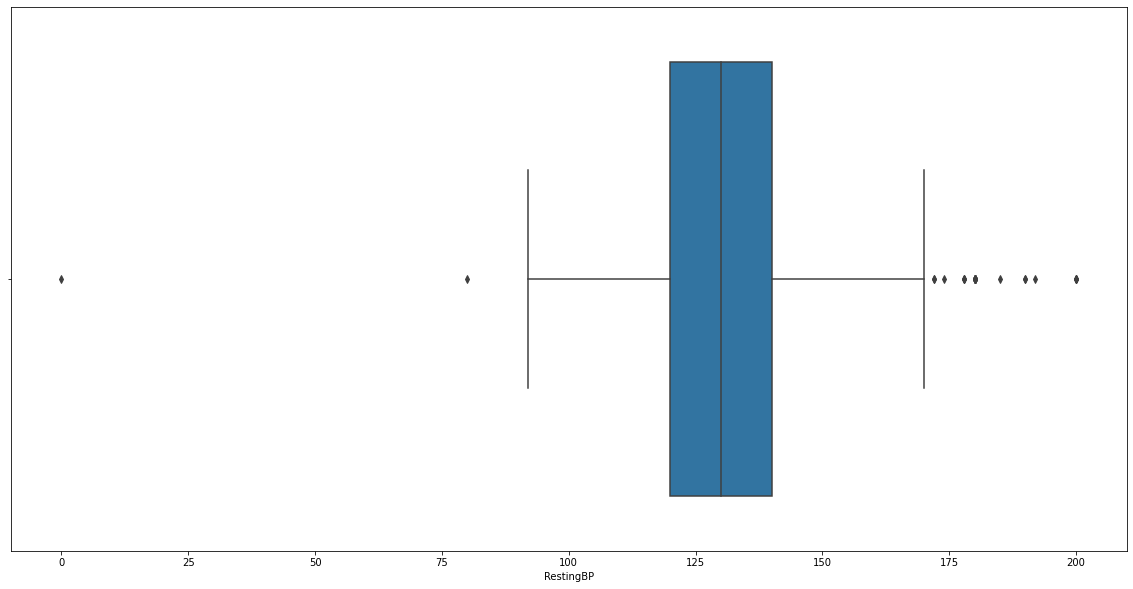

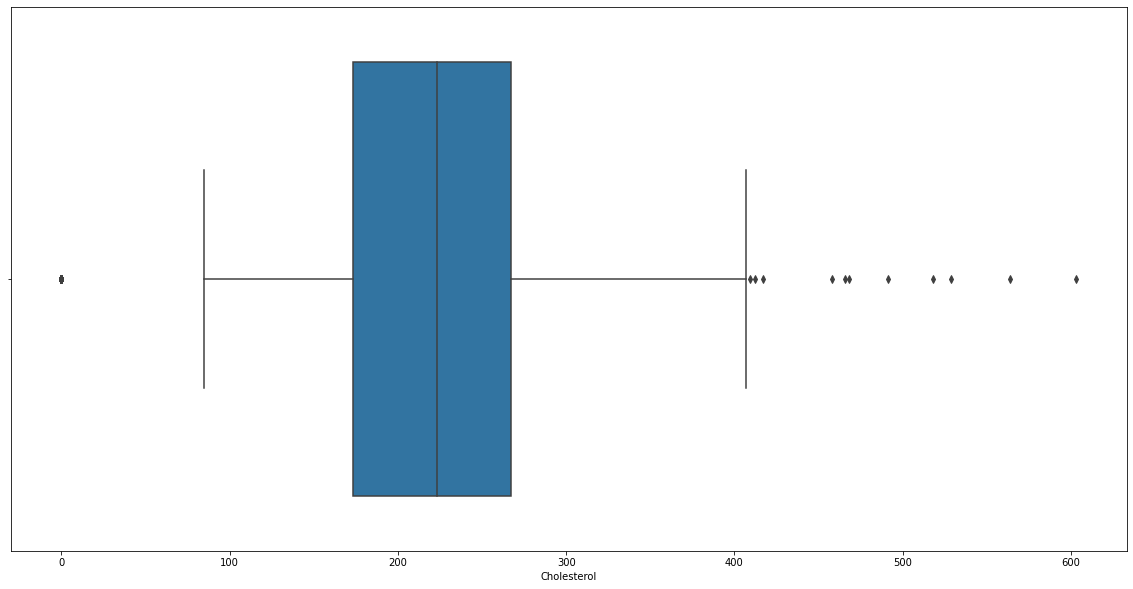

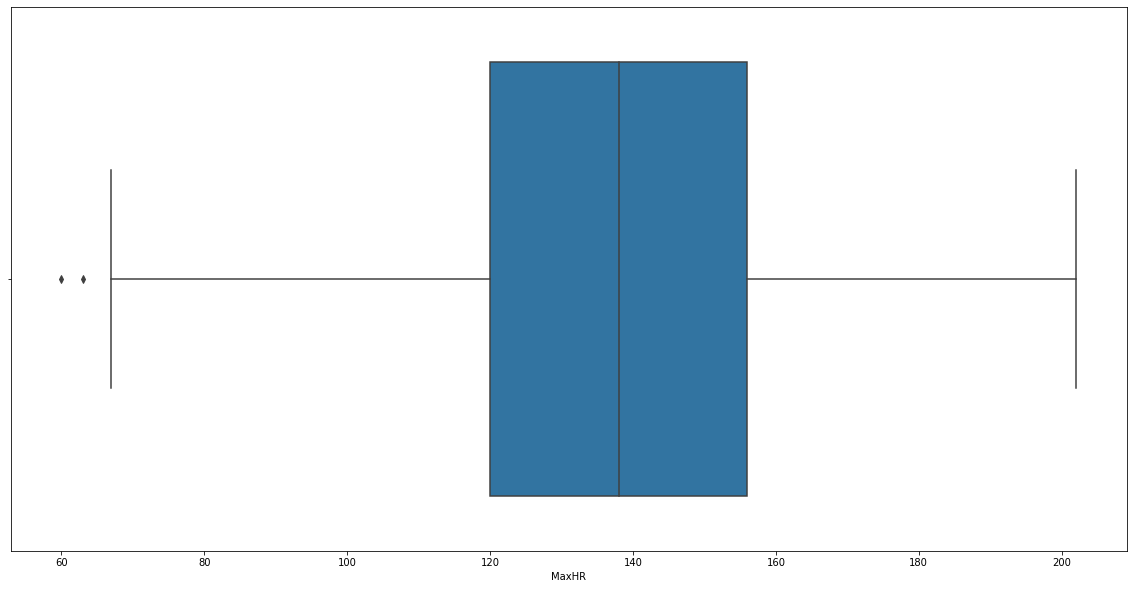

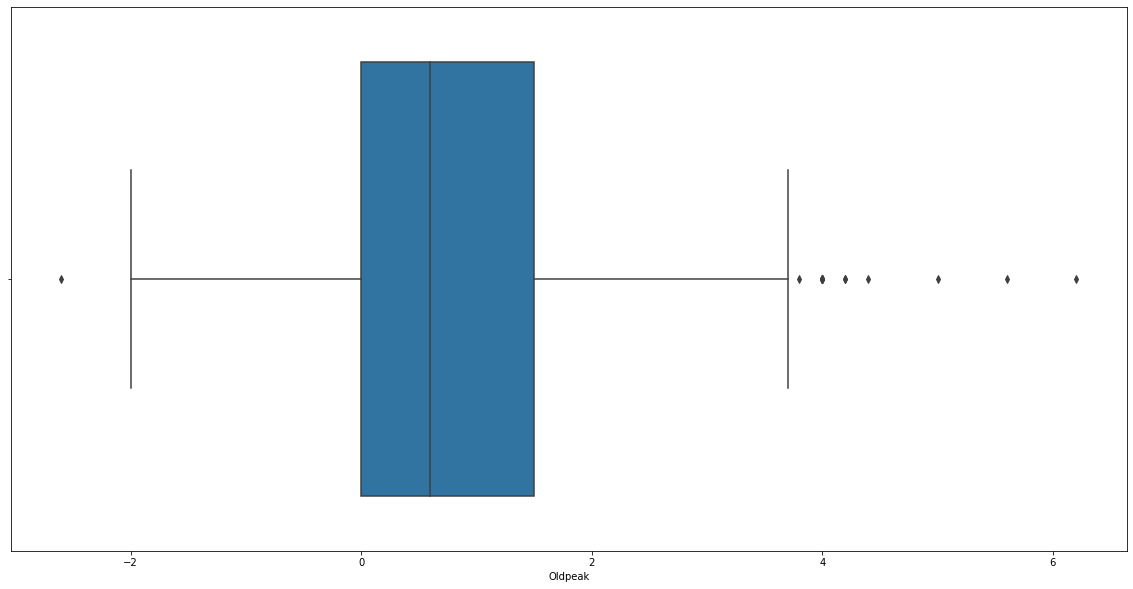

In [16]:
for numerical_feature in numerical_features:
    plot_intercuartile_range(numerical_feature)

### Multivariate Analysis

The target column in this case is very clear, HeartDisease. We already know that it is not balanced, but know we will try to detect any pattern. 

#### Numerical features: Plots

In [34]:
def distribution_acording_to_target_value(variable_name):
    plt.figure(figsize=(20, 10))
    plt.title(f"Distribution of {variable_name}")
    ax = sns.violinplot(x="HeartDisease", y=f"{variable_name}",
                    data=data, palette="Set2", split=True,
                    scale="count")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/violin_{variable_name}.png")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(20, 10))
    ax = sns.boxplot(x="HeartDisease", y=f"{variable_name}", data=data, palette="Set2")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/distribution_{variable_name}_target.png")
    plt.show()
    plt.close()

ValueError: Could not interpret input 'O'

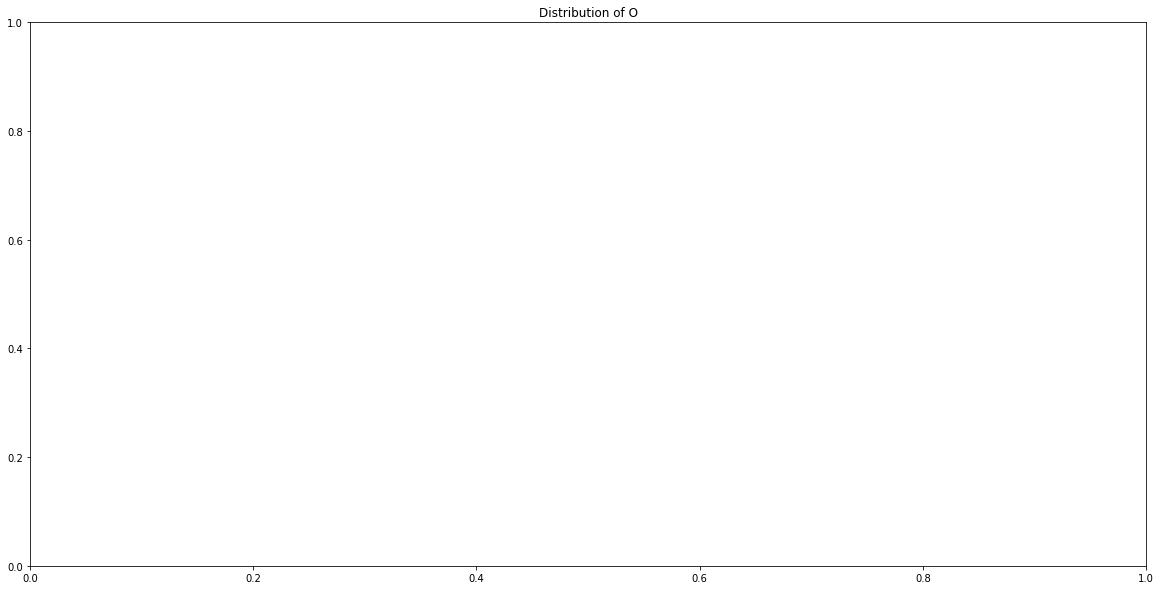

In [35]:
for numerical_feature in numerical_features: 
    distribution_acording_to_target_value(numerical_feature)
    

#### Categorical features: Plots

In [36]:
def categorical_distribution_acording_to_target_value(variable_name):
    plt.figure(figsize=(20, 10))
    plt.title(f"Distribution of {variable_name}")
    ax = sns.countplot(x=f"{variable_name}", hue="HeartDisease", data=data)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=14)
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/distribution_{variable_name}_targetb.png")
    plt.show()
    plt.close()

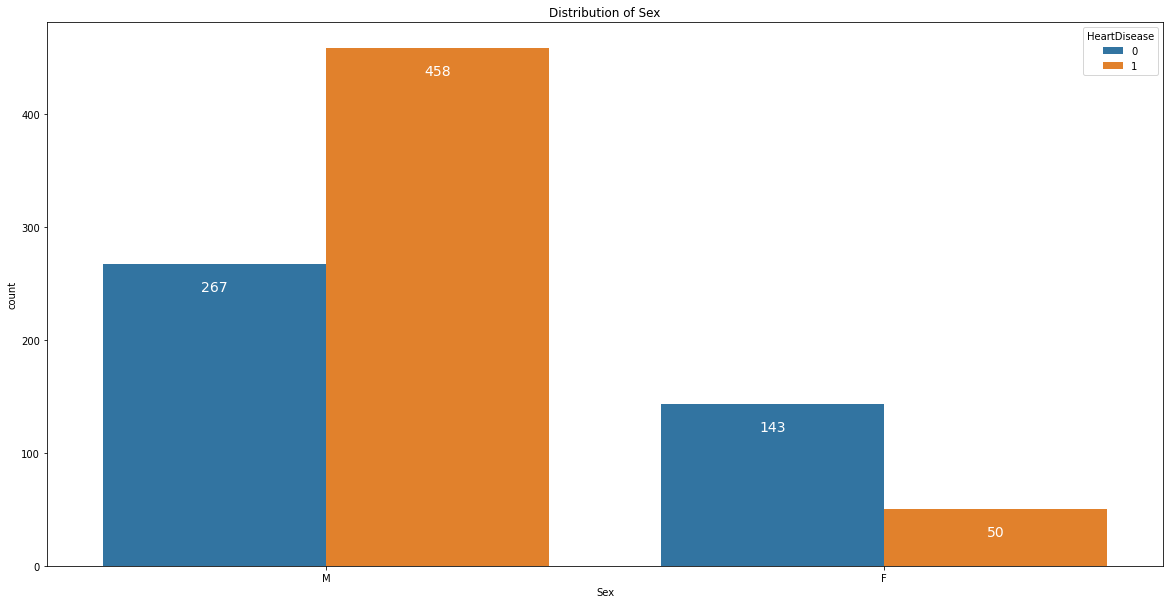

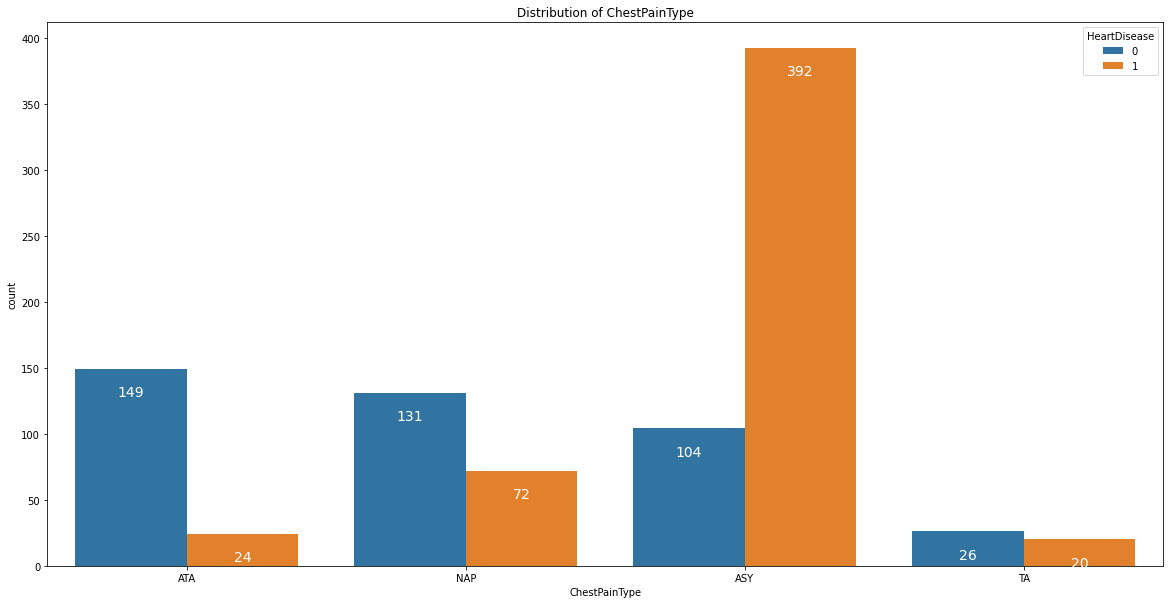

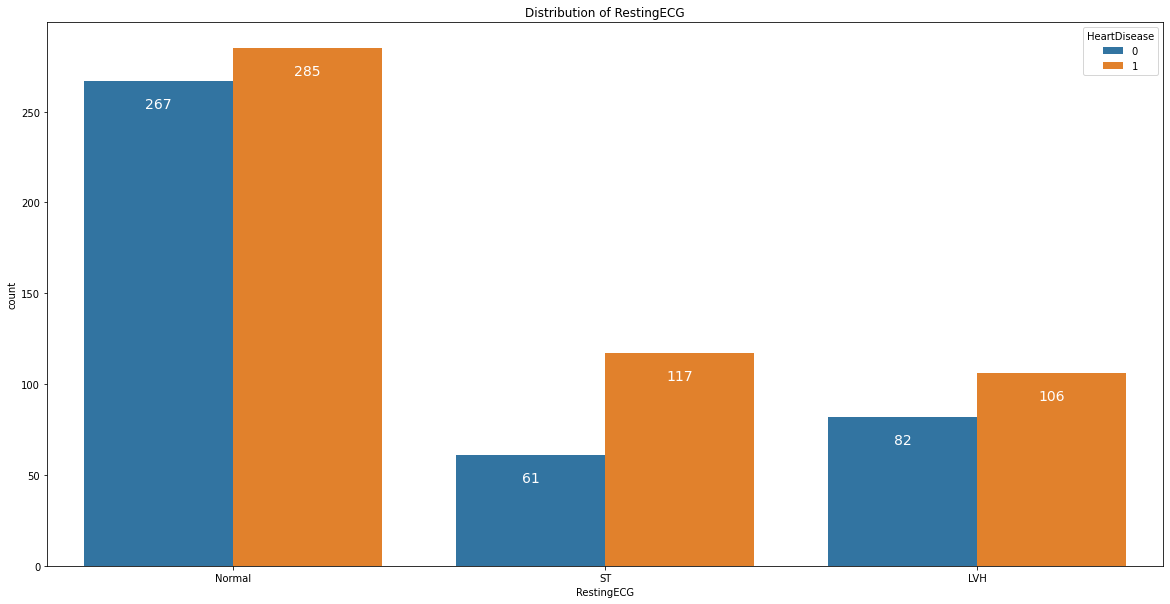

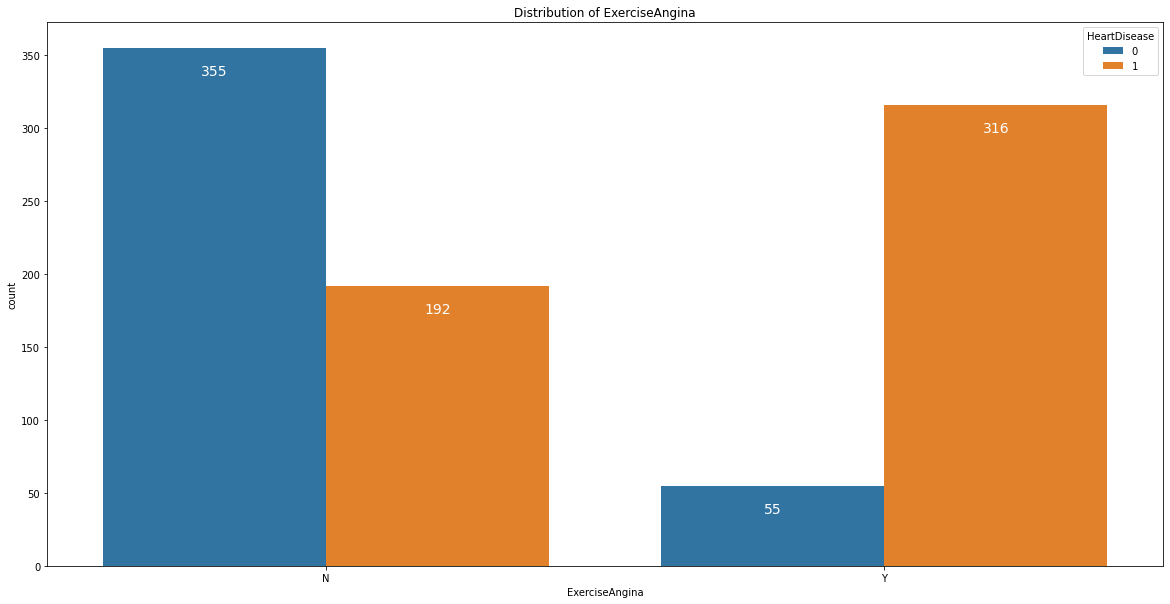

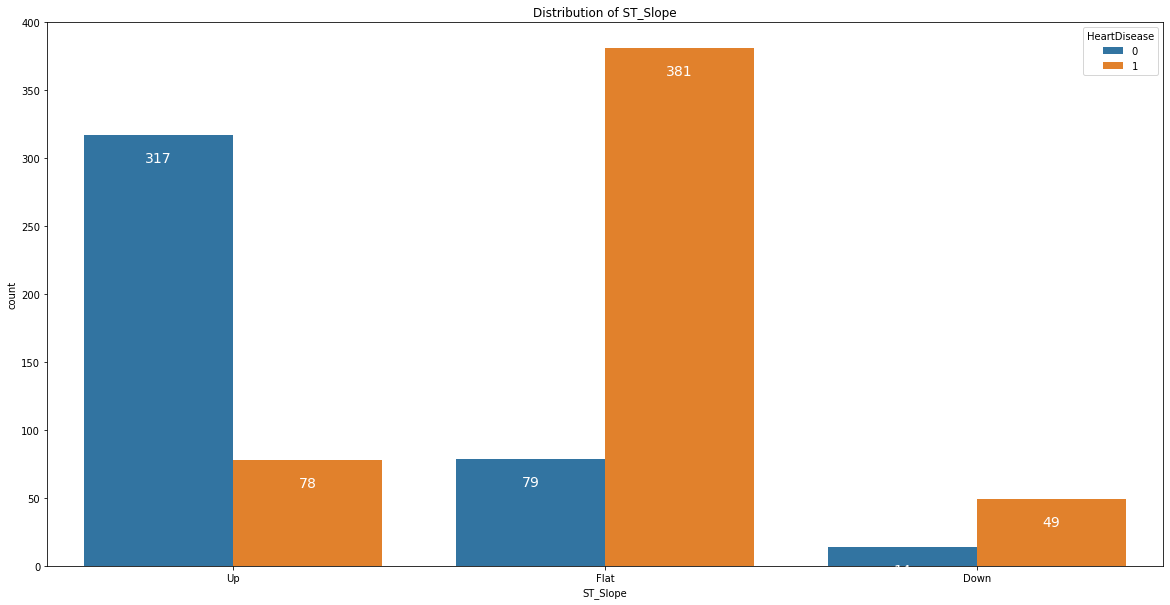

In [41]:
for categorical_feature in categorical_features[:-1]: 
    categorical_distribution_acording_to_target_value(categorical_feature)

#### ANOVA analysis

The idea of this analysis is to see if there is any connection between the target values and the different variables. 

#### Correlations